<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/LPPL_REAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LPPL Model Implementation to Predict Financial Bubbles

In this notebook, we'll implement the Log-Periodic Power Law (LPPL) model to analyze past financial bubbles and attempt to predict potential future bubbles using current market data.

In [26]:
# Install necessary libraries if not already installed
# Uncomment the following lines if you need to install the packages
!pip install yfinance numpy pandas matplotlib lmfit

# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Parameters, minimize, report_fit


In [27]:
# Define the LPPL model function
def lppl(t, A, B, C, tc, m, omega, phi):
    dt = tc - t
    dt = np.where(dt > 0, dt, 1e-6)  # Ensure dt is positive
    return A + B * dt**m + C * dt**m * np.cos(omega * np.log(dt) + phi)

# Define the residual function for optimization
def residual(params, t, data):
    A = params['A'].value
    B = params['B'].value
    C = params['C'].value
    tc = params['tc'].value
    m = params['m'].value
    omega = params['omega'].value
    phi = params['phi'].value
    model = lppl(t, A, B, C, tc, m, omega, phi)
    return data - model


In [28]:
# Download market data
symbol = '^GSPC'
data = yf.download(symbol, start='2015-01-01', end=pd.Timestamp.today())
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

# Create time variables
data['t'] = (data['Date'] - data['Date'].iloc[0]).dt.total_seconds() / (3600 * 24)
data['lnP'] = np.log(data['Adj Close'])


[*********************100%***********************]  1 of 1 completed


In [29]:
# Set window size and step size
window_size = 252 * 2  # 2 years of trading days
step_size = 20  # Move window every 20 days

t_all = data['t'].values
P_all = data['lnP'].values

results = []

for start in range(0, len(data) - window_size, step_size):
    end = start + window_size
    t = t_all[start:end]
    P = P_all[start:end]
    dates = data['Date'].iloc[start:end]

    # Set initial parameters and bounds
    params = Parameters()
    params.add('A', value=np.mean(P), min=min(P), max=max(P))
    params.add('B', value=-1, min=-100, max=0)
    params.add('C', value=1, min=-10, max=10)
    params.add('tc', value=t[-1] + 30, min=t[-1] + 1, max=t[-1] + 500)
    params.add('m', value=0.5, min=0.1, max=1)
    params.add('omega', value=7.5, min=0.1, max=25)
    params.add('phi', value=0, min=-np.pi, max=np.pi)

    # Perform the optimization
    try:
        result = minimize(residual, params, args=(t, P), method='leastsq')

        # Calculate goodness of fit
        residuals = residual(result.params, t, P)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((P - np.mean(P))**2)
        r_squared = 1 - (ss_res / ss_tot)

        # Store results including all parameters
        results.append({
            'start_date': dates.iloc[0],
            'end_date': dates.iloc[-1],
            'tc': result.params['tc'].value,
            'A': result.params['A'].value,
            'B': result.params['B'].value,
            'C': result.params['C'].value,
            'm': result.params['m'].value,
            'omega': result.params['omega'].value,
            'phi': result.params['phi'].value,
            'r_squared': r_squared
        })
    except Exception as e:
        print(f"Optimization failed for window starting at {dates.iloc[0]}: {e}")
        continue


In [30]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Filter periods with high R-squared value
threshold = 0.8
bubble_periods = results_df[results_df['r_squared'] >= threshold]

print("Potential bubble periods identified:")
print(bubble_periods[['start_date', 'end_date', 'tc', 'r_squared']])


Potential bubble periods identified:
                  start_date                  end_date           tc  r_squared
10 2015-10-19 00:00:00+00:00 2017-10-17 00:00:00+00:00  1057.142869   0.893650
11 2015-11-16 00:00:00+00:00 2017-11-14 00:00:00+00:00  1132.438956   0.882590
12 2015-12-15 00:00:00+00:00 2017-12-13 00:00:00+00:00  1082.073933   0.940552
13 2016-01-14 00:00:00+00:00 2018-01-12 00:00:00+00:00  1125.078388   0.945835
14 2016-02-12 00:00:00+00:00 2018-02-12 00:00:00+00:00  1152.822147   0.966386
15 2016-03-14 00:00:00+00:00 2018-03-13 00:00:00+00:00  1198.779414   0.972295
16 2016-04-12 00:00:00+00:00 2018-04-11 00:00:00+00:00  1297.943107   0.910128
17 2016-05-10 00:00:00+00:00 2018-05-09 00:00:00+00:00  1264.144998   0.903670
18 2016-06-08 00:00:00+00:00 2018-06-07 00:00:00+00:00  1286.117100   0.911015
19 2016-07-07 00:00:00+00:00 2018-07-06 00:00:00+00:00  1312.699482   0.902436
20 2016-08-04 00:00:00+00:00 2018-08-03 00:00:00+00:00  1339.928001   0.886129
21 2016-09-01 0

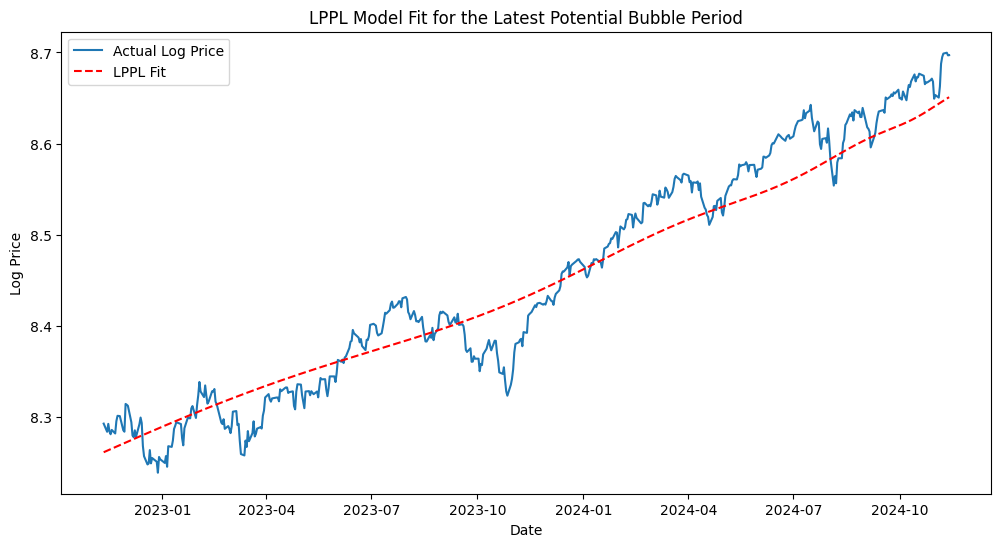

Estimated crash date (tc): 2025-01-10


In [31]:
# Check if any bubble periods are detected
if not bubble_periods.empty:
    # Select the most recent bubble period
    latest_bubble = bubble_periods.iloc[-1]
    start_idx = data.index[data['Date'] == latest_bubble['start_date']][0]
    end_idx = data.index[data['Date'] == latest_bubble['end_date']][0]
    t = t_all[start_idx:end_idx+1]
    P = P_all[start_idx:end_idx+1]
    dates = data['Date'].iloc[start_idx:end_idx+1]

    # Reconstruct parameters for the model
    params = Parameters()
    params.add('A', value=latest_bubble['A'])
    params.add('B', value=latest_bubble['B'])
    params.add('C', value=latest_bubble['C'])
    params.add('tc', value=latest_bubble['tc'])
    params.add('m', value=latest_bubble['m'])
    params.add('omega', value=latest_bubble['omega'])
    params.add('phi', value=latest_bubble['phi'])

    # Generate fitted values
    P_fit = lppl(t, **params.valuesdict())

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(dates, P, label='Actual Log Price')
    plt.plot(dates, P_fit, 'r--', label='LPPL Fit')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Log Price')
    plt.title('LPPL Model Fit for the Latest Potential Bubble Period')
    plt.show()

    # Estimate the crash date
    tc_estimated = params['tc'].value
    tc_date = data['Date'].iloc[0] + pd.Timedelta(days=tc_estimated)
    print(f"Estimated crash date (tc): {tc_date.date()}")
else:
    print("No potential bubble patterns detected in the current market data.")
